<a href="https://colab.research.google.com/github/taschoebli/ml_coding_challenge_1schnitzel_2bratwurst/blob/main/ML_coding_challenge_1_Schnitzel_2_Bratw%C3%BCrst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="center" style="max-width: 900px; height: auto" src="https://github.com/HSG-AIML-Teaching/ML2024-Lab/blob/main/banner.png?raw=1">

###  Coding Challenge - Getting Started

<img align="right" style="max-width: 200px; height: auto" src="https://github.com/HSG-AIML-Teaching/ML2024-Lab/blob/main/cc_1/hsg_logo.png?raw=1">
<img align="center" style="max-width: 300px; height: auto" src="https://github.com/HSG-AIML-Teaching/ML2024-Lab/blob/main/cc_1/sentinel2.jpg?raw=1">

8,860,1.00 MCS Machine Learning, Spring Term 2024, University of St.Gallen (HSG)

The lab environment of the **8,860,1.00 Machine Learning** course is powered by Jupyter Notebooks (https://jupyter.org), which allows one to perform a great deal of data analysis and statistical validation. In this first lab, we want to touch on the basic concepts and techniques of such notebooks. Furthermore, its capabilities will be demonstrated based on a few simple and introductory examples.

### Objectives:

With the help of this notebook you should be able to:
    
> 1. Understand the basic funcitonality of the rasterio framework
> 2. Apply rasterio to load GTiff data
> 3. Visualize multi-band satellite imagery
> 4. Perform basic band arithmetic to compute the normalized difference vegetation index (NDVI)
> 5. Load and display samples from the challenge testset

## 2. Setup of the Jupyter Notebook Environment

How to download kaggle data in Google Colab

https://www.kaggle.com/discussions/general/74235

In [4]:
!pip install -q kaggle

In [ ]:
#create kaggle folder with access key
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

In [6]:
#get testdata (inside zip folder)
!kaggle competitions download -c aiml-coding-challenge-fs24

 96% 291M/303M [00:02<00:00, 140MB/s]
100% 303M/303M [00:02<00:00, 121MB/s]


In [7]:
#create directory
!mkdir testdata

#unzip the data
!unzip aiml-coding-challenge-fs24.zip -d testdata


Archive:  aiml-coding-challenge-fs24.zip
  inflating: testdata/sample_submission.csv  
  inflating: testdata/test.csv       
  inflating: testdata/testset/testset/test_0.npy  
  inflating: testdata/testset/testset/test_1.npy  
  inflating: testdata/testset/testset/test_10.npy  
  inflating: testdata/testset/testset/test_100.npy  
  inflating: testdata/testset/testset/test_1000.npy  
  inflating: testdata/testset/testset/test_1001.npy  
  inflating: testdata/testset/testset/test_1002.npy  
  inflating: testdata/testset/testset/test_1003.npy  
  inflating: testdata/testset/testset/test_1004.npy  
  inflating: testdata/testset/testset/test_1005.npy  
  inflating: testdata/testset/testset/test_1006.npy  
  inflating: testdata/testset/testset/test_1007.npy  
  inflating: testdata/testset/testset/test_1008.npy  
  inflating: testdata/testset/testset/test_1009.npy  
  inflating: testdata/testset/testset/test_101.npy  
  inflating: testdata/testset/testset/test_1010.npy  
  inflating: testdata

Similar to the previous labs, we need to import a couple of Python libraries that allow for data analysis and data visualization. We will use `os` and `glob` to collect the filepaths for the data samples, `numpy` for array operations, `matplotlib` to display images, and `rasterio` to handle raster data. You can find the documentation of the `rasterio` library with an overview of its functionality [here](https://rasterio.readthedocs.io).

In [8]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 16.9 MB/s eta 0:00:00


In [9]:
import fnmatch
import glob
import numpy as np
import os
import rasterio as rio
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt
%matplotlib inline

### Dataset Download
<img align="center" style="max-width: 300px; height: auto" src="https://github.com/HSG-AIML-Teaching/ML2024-Lab/blob/main/cc_1/eurosat.png?raw=1">

The Eurosat dataset is available on [github](https://github.com/phelber/EuroSAT). You can download and unpack the data from there. Note that this repository includes RGB and multi-spectral versions of Eurosat. Note that the testdata is multi-spectral.

The multi-spectral (MS) version can be downloaded with the following command:

In [10]:
!wget https://madm.dfki.de/files/sentinel/EuroSATallBands.zip --no-check-certificate

--2024-03-06 16:38:06--  https://madm.dfki.de/files/sentinel/EuroSATallBands.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 2067725275 (1.9G) [application/zip]
Saving to: ‘EuroSATallBands.zip’

EuroSATallBands.zip 100%[===================>]   1.92G  27.9MB/s    in 73s     

2024-03-06 16:39:19 (27.2 MB/s) - ‘EuroSATallBands.zip’ saved [2067725275/2067725275]



### Eurosat classes

The class-labels can be derived from the directory structure of the downloaded `zip` file. The 10 classes are as follows:

In [11]:
classes = [
    "AnnualCrop",
    "Forest",
    "HerbaceousVegetation",
    "Highway",
    "Industrial",
    "Pasture",
    "PermanentCrop",
    "Residential",
    "River",
    "SeaLake",
]

### Data visualization
Let's define a function to visualize the Eurosat data with `matplotlib`. In the 13-band multispectral images of Sentinel-2, the 13 values of each pixel correspond to the reflectance values at different wavelengths. These numbers are not normalized for visualization with `matplotlib`, which expects inputs to be `int` in the `[0-255]` or `float` in the `[0.-1.]` range.

In [12]:
def normalize_for_display(band_data):
    """Normalize multi-spectral imagery across bands.
    The input is expected to be in HxWxC format, e.g. 64x64x13.
    To account for outliers (e.g. extremly high values due to
    reflective surfaces), we normalize with the 2- and 98-percentiles
    instead of minimum and maximum of each band.
    """
    band_data = np.array(band_data)
    lower_perc = np.percentile(band_data, 2, axis=(0,1))
    upper_perc = np.percentile(band_data, 98, axis=(0,1))

    return (band_data - lower_perc) / (upper_perc - lower_perc)

## EuroSat Data Loading

First, let's collect all the files that we downloaded

In [13]:
#create directory for eurosatdata and put unzipped data there
!mkdir eurosatdata
!unzip EuroSATallBands.zip -d eurosatdata


Streaming output truncated to the last 5000 lines.
  inflating: eurosatdata/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/SeaLake/SeaLake_2294.tif  
  inflating: eurosatdata/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/SeaLake/SeaLake_1854.tif  
  inflating: eurosatdata/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/SeaLake/SeaLake_1426.tif  
  inflating: eurosatdata/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/SeaLake/SeaLake_1381.tif  
  inflating: eurosatdata/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/SeaLake/SeaLake_647.tif  
  inflating: eurosatdata/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/SeaLake/SeaLake_581.tif  
  inflating: eurosatdata/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/SeaLake/SeaLake_226.tif  
  inflating: eurosatdata/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/SeaLake/SeaLake_2819.tif  
  inflating: eurosatdata/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/SeaLake/SeaLake_922.tif  

In [14]:
eurosatdata_dir = "/content/eurosatdata"

In [15]:
def find_files(directory, ending):
    """
    Recursively find all '.tif' files within a directory and its subdirectories.

    Parameters:
    - directory (str): The path to the directory to search in.

    Returns:
    - List[str]: A list of paths to the '.tif' files found.
    """
    tif_files = []

    for root, dirs, files in os.walk(directory):
        for file in fnmatch.filter(files, ending):
            tif_files.append(os.path.join(root, file))

    return tif_files

In [16]:
samples = find_files(eurosatdata_dir, '*.tif')
len(samples)

27000

We have 27,000 files across 10 classes.

Let's load one of those multi-spectral images and try to visualize it.

In [17]:
sample_idx = 25470
sample = samples[sample_idx]
label = sample.split('/')[-1].split('_')[0]

We can use `rasterio.open` to open the `GTiff` file. We can then `read` from the file. By default `read()` without arguments will load all bands. Individual bands can be specified as a list with one-based indices. Therefore, the RGB bands can be read with `read([4,3,2])`.

In [18]:
with rio.open(sample, "r") as d:
    # img = d.read() # read all bands

    # read specific bands:
    # B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B10,B11,B12
    img = d.read([1,2,3,4,5,6,7,8,9,10,11,12,13])

img.shape

(13, 64, 64)

We load the data into the `img` variable. This results in a `numpy` array with shape `(13,64,64)`, i.e. `CxHxW`. This differs from the convention of most image libraries like `matplotlib`, which work on image data in the `HxWxC` orientation. `rasterio` provides a function to easily fix this:

In [19]:
img = reshape_as_image(img)
img.shape

(64, 64, 13)

Now let's normalize the data.

In [20]:
normalized_img = normalize_for_display(img)

Finally, we can extract the RGB bands and visualize them with `matplotlib`.

In [21]:
rgb_img = normalized_img[:, :, [3,2,1]]

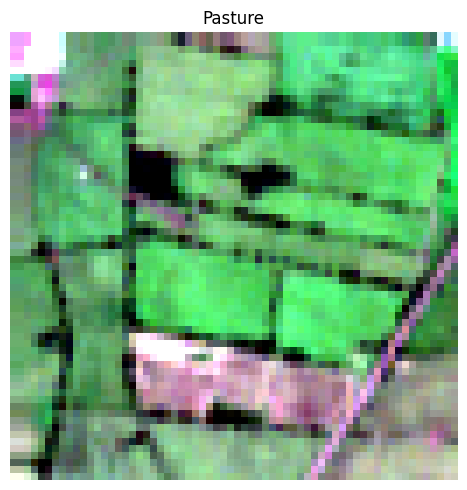

In [22]:
fig, ax = plt.subplots(1, figsize=(5,5))
ax.imshow(rgb_img)
ax.set_title(f"{label}")
ax.axis(False)
plt.tight_layout()

plt.show()

Note the `matplotlib` warning. Since we normalized the data by percentiles instead of maximum and minimum some (rare) pixels exceed the `[0.-1.]` range that `matplotlib` can handle. In such cases, the values are clipped to `1.`.

# Testset Data Loading

The testset has a slightly different structure than Eurosat. There are no labels and the data is stored in `numpy` `.npy` instead of GTiff.

First, we have to download the data from [Kaggle](https://www.kaggle.com/competitions/aiml-coding-challenge-fs23/data).

In [23]:
# change this to your testdata path
testdata_path = '/content/testdata'


In [24]:
test_samples = find_files(testdata_path, "*.npy")

In [25]:
#sort test samples
import re
test_samples = sorted(test_samples, key=lambda x: int(re.search(r'test_(\d+).npy', x).group(1)))

In [26]:
#Check
print(len(test_samples))

#first three elements
print(test_samples[0:2])

4232
['/content/testdata/testset/testset/test_0.npy', '/content/testdata/testset/testset/test_1.npy']


Now let's visualize a sample as we did for Eurosat

In [27]:
test_idx = 854

In [28]:
test_img = np.load(test_samples[test_idx])
test_img.shape

(64, 64, 12)

Then normalize the data and extract RGB channels

In [29]:
normalized_img = normalize_for_display(test_img)

In [30]:
rgb_img = normalized_img[:, :, [3,2,1]]

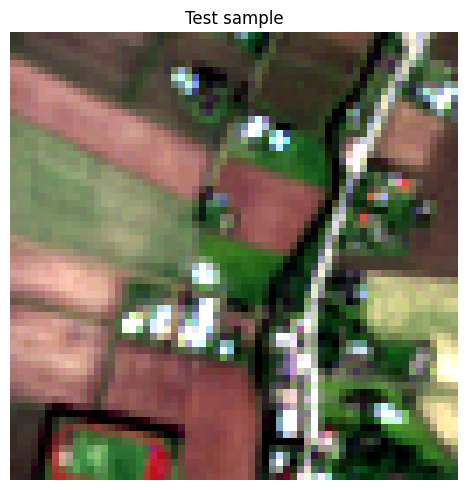

In [31]:
fig, ax = plt.subplots(1, figsize=(5,5))
ax.imshow(rgb_img)
ax.set_title(f"Test sample")
ax.axis(False)
plt.tight_layout()

plt.show()

### Bonus: Band arithmetic
The normalized difference vegetation index, or NDVI, is one of the most useful indices that can be derived from multi-spectral remote sensing data and indicates the presence of live green vegeation in an area.

> The pigment in plant leaves, chlorophyll, strongly absorbs visible light (from 400 to 700 nm) for use in photosynthesis. The cell structure of the leaves, on the other hand, strongly reflects near-infrared light (from 700 to 1100 nm).

From [Wikipedia](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index)

The NDVI exploits this difference in reflective properties of plants. It is computed as the ratio of the difference with the sum of near-infrared and red color bands. For the Sentinel2 data, this corresponds to the following:

`NDVI = (B8-B4)/(B8+B4)`

In [32]:
sample = samples[10]
label = sample.split('/')[-1].split('_')[0]

with rio.open(sample, "r") as d:
    img = d.read([1,2,3,4,5,6,7,8,9,10,11,12,13])

img = reshape_as_image(img)
normalized_img = normalize_for_display(img)
rgb_img = normalized_img[:, :, [3,2,1]]

Extract bands 4 and 8 from the data.

In [33]:
b8 = img[:, :, 7]
b4 = img[:, :, 3]

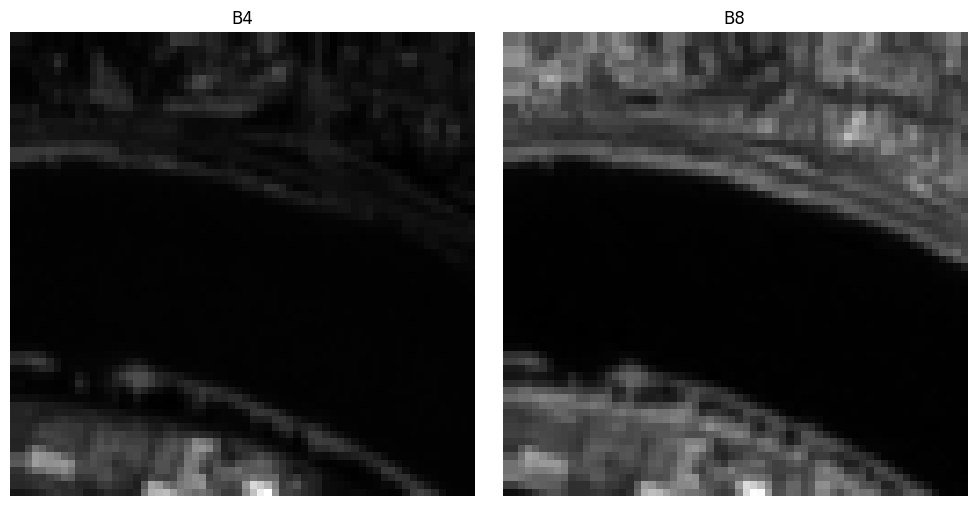

In [34]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].imshow(b4, cmap="gray")
axs[0].set_title("B4")
axs[0].axis(False)

axs[1].imshow(b8, cmap="gray")
axs[1].set_title("B8")
axs[1].axis(False)

plt.tight_layout()
plt.show()

Compute the NDVI:

In [35]:
ndvi = (b8-b4) / (b8+b4)

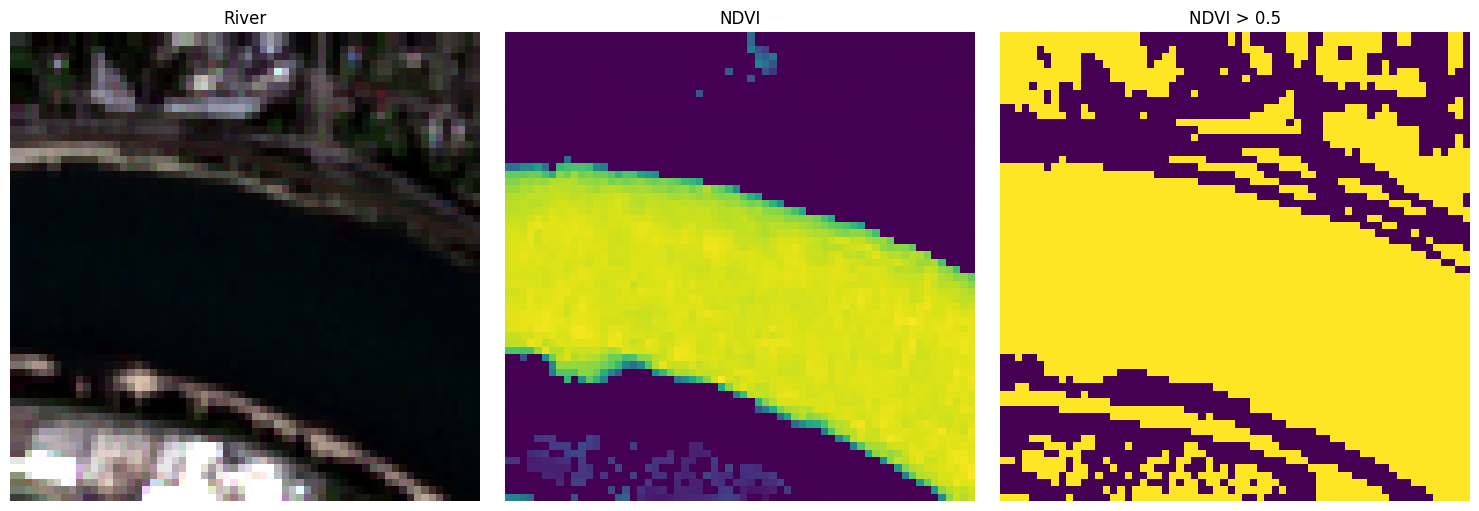

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

ax1.imshow(rgb_img)
ax1.set_title(f"{label}")
ax1.axis(False)

ax2.imshow(ndvi)
ax2.set_title(f"NDVI")
ax2.axis(False)

ax3.imshow(ndvi > .5)
ax3.set_title(f"NDVI > 0.5")
ax3.axis(False)

plt.tight_layout()
plt.show()

We can easily threshold NDVI values to obtain a segmentation mask of the vegetation in the image.

Let's also look at the bands individually.

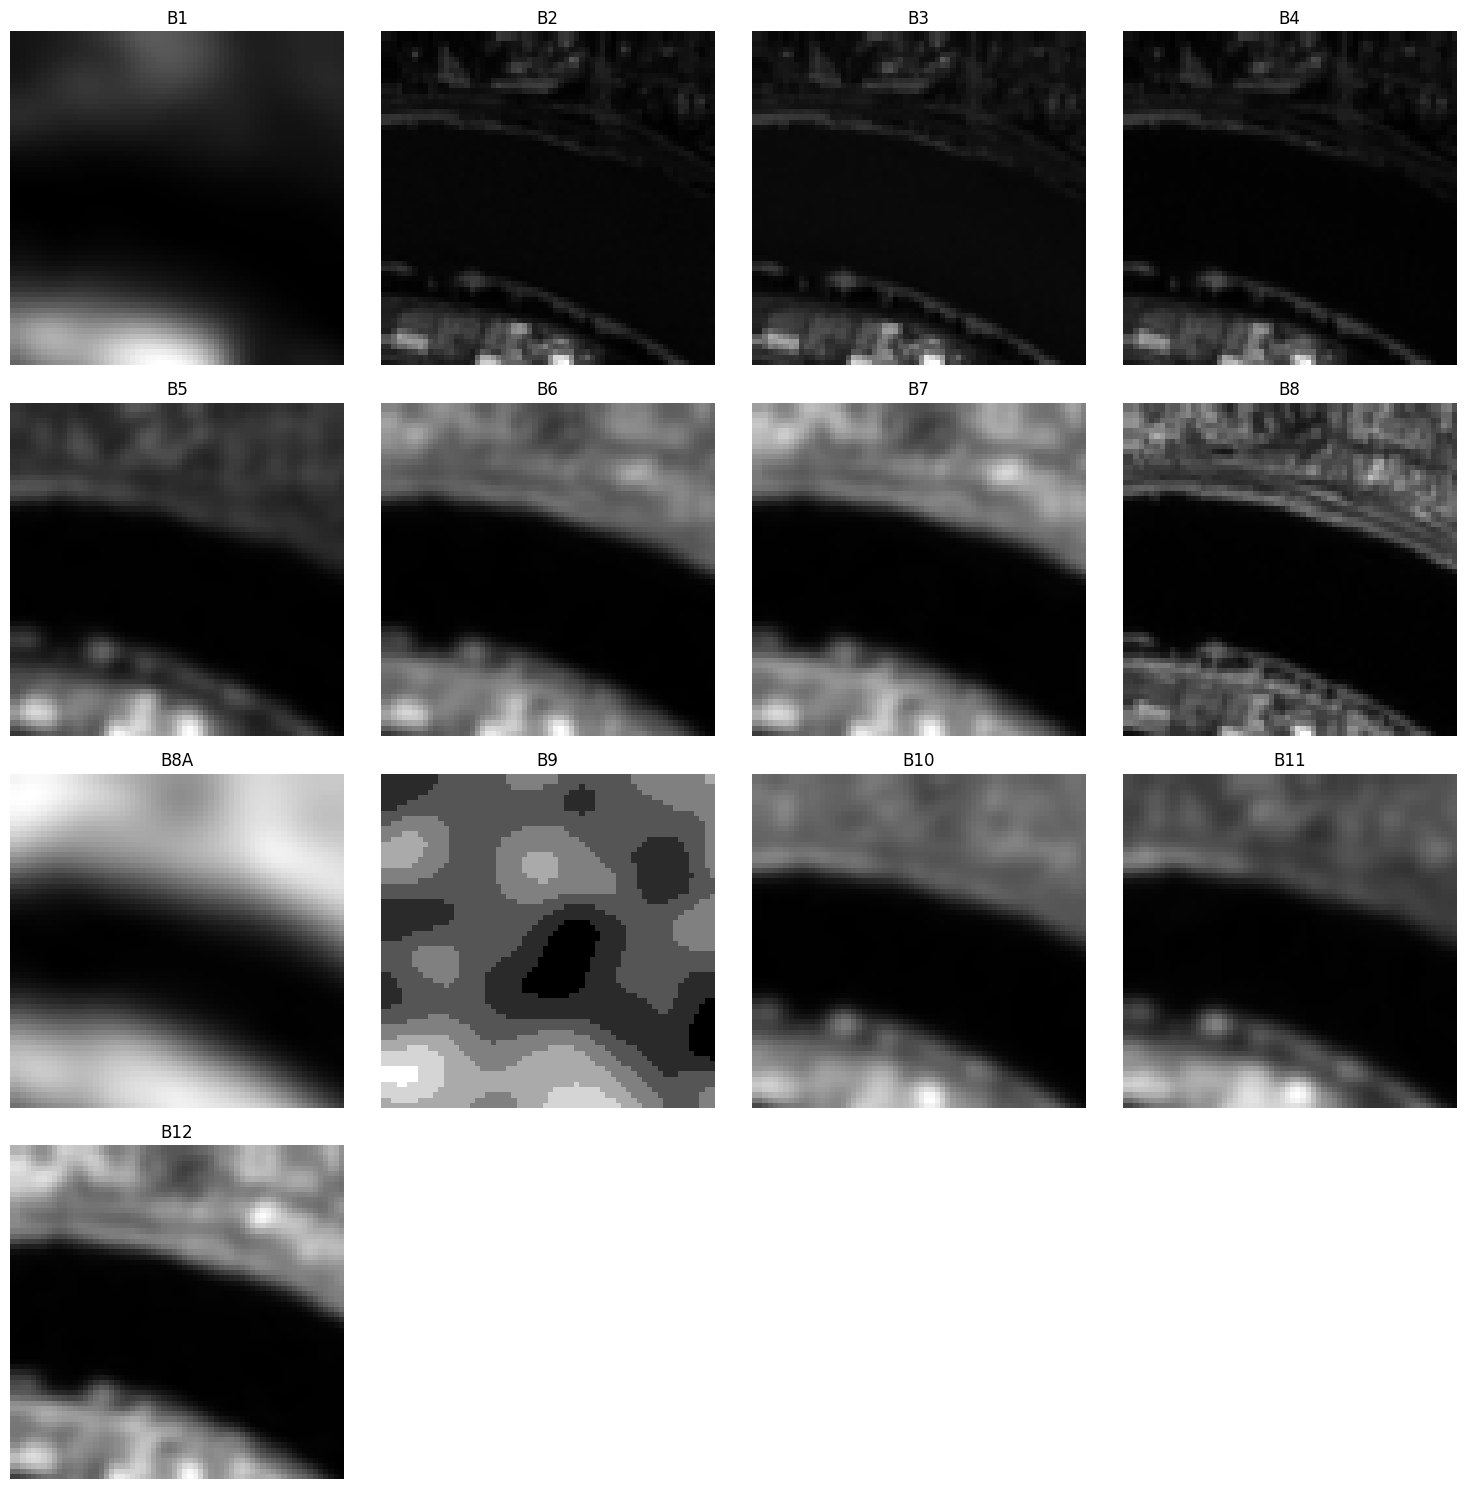

In [37]:
fig, axs = plt.subplots(4,4, figsize=(15,15))

band_idx = 0
bands = ["B1","B2","B3","B4","B5","B6","B7","B8","B8A","B9","B10","B11","B12"]

for i in range(4):
    for j in range(4):
        if band_idx < 13:
            axs[i,j].imshow(normalized_img[:, :, band_idx], cmap="gray")
            axs[i,j].set_title(bands[band_idx])
        else:
            axs[i,j].imshow(np.ones((64,64,3)), cmap="gray")

        axs[i,j].axis(False)
        band_idx += 1

plt.tight_layout()
plt.show()

## Next steps

Create a (deep learning) model to predict the most likely Eurosat class for each image of the testset. Think about creating the dataset class and data-loader for training, possible model architectures, and perhaps even how to best address the shift between train and test data.

### Prepare Data for Deep Learning

In [38]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [39]:
#prepare EuroSat data for model
#create images and labels list
images = []
labels = []
for sample in samples:
  with rio.open(sample, "r") as d:
    #read all Bands
    img = d.read()
    img = reshape_as_image(img)
    normalized_img = normalize_for_display(img)
    rgb_img = normalized_img[:, :, [3,2,1]]
    label = sample.split('/')[-1].split('_')[0]
    images.append(rgb_img)
    labels.append(label)

<ipython-input-12-6d4807d13447>:12: RuntimeWarning: invalid value encountered in divide
  return (band_data - lower_perc) / (upper_perc - lower_perc)


In [40]:
print(images[5202].shape)
print(labels[5202])

(64, 64, 3)
HerbaceousVegetation


In [41]:
eval_fraction = 0.2

In [42]:
# 80% training and 20% evaluation
train_data, validation_data, train_labels, validation_labels = train_test_split(images, labels, test_size=eval_fraction, random_state=None, stratify=None)

In [43]:
print(len(train_data))
print(len(validation_data))
print(len(train_labels))
print(len(validation_labels))
print(train_data[4300].shape)
print(train_labels[4300])

21600
5400
21600
5400
(64, 64, 3)
SeaLake


In [44]:
#convert list of data and labels into NumPy arrays.
train_data_np = np.array(train_data)
train_labels_np = np.array(train_labels)
validation_data_np = np.array(validation_data)
validation_labels_np = np.array(validation_labels)

In [45]:
#encode categorical labels (=strings) into format suitable for training
label_encoder = LabelEncoder()
train_labels_np = label_encoder.fit_transform(train_labels_np)
validation_labels_np = label_encoder.fit_transform(validation_labels_np)

### Train Model

In [46]:
number_of_classes = 10

# Load ResNet50 with pre-trained ImageNet weights, excluding the top layer
# No need to adjust for input channels since we're using standard RGB images
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze all layers in the base model to prevent their weights from being updated during training
for layer in base_model.layers:
    layer.trainable = False

# Add new classifier layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convert features to vectors
x = Dense(1024, activation='relu')(x)  # New FC layer, adjust units according to needs
predictions = Dense(number_of_classes, activation='softmax')(x)  # New softmax layer

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
# use categorical_crossentropy if labels as onet-to-hot
# use sparse_categorical_crossentropy if labels are integers
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary to check the final model architecture
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 70, 70, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 32, 32, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1_conv[0][0]']          
 on)                         

In [47]:
#reduce size of data
factor = 50
train_data_np = train_data_np[0:(len(train_data_np)//factor)]
train_labels_np = train_labels_np[0:(len(train_labels_np)//factor)]
validation_data_np = validation_data_np[0:(len(validation_data_np)//factor)]
validation_labels_np = validation_labels_np[0:(len(validation_labels_np)//factor)]

In [48]:
print(train_data_np.shape)
print(train_labels_np.shape)
print(validation_data_np.shape)
print(validation_labels_np.shape)

(432, 64, 64, 3)
(432,)
(108, 64, 64, 3)
(108,)


In [49]:
print(train_labels_np)

[6 7 2 9 3 6 7 2 8 1 3 0 3 3 8 7 5 5 5 4 0 3 2 3 2 8 7 2 1 7 6 0 9 0 9 4 3
 6 1 7 1 2 8 9 7 0 4 2 8 4 9 6 9 7 4 3 1 9 4 1 5 9 6 6 4 2 3 3 8 1 1 5 8 4
 3 0 8 3 4 2 0 0 6 1 7 2 6 5 6 7 3 1 5 8 4 7 5 4 0 5 8 8 2 2 4 6 2 6 9 5 4
 3 9 0 6 7 6 4 7 2 3 9 8 7 6 8 0 2 0 4 1 9 2 3 8 6 0 1 5 4 8 3 9 1 9 1 2 5
 2 6 9 4 0 7 0 6 6 2 5 2 1 0 3 3 6 7 4 1 0 7 9 7 5 0 5 8 2 3 5 8 5 2 8 5 9
 1 5 7 0 6 0 1 0 1 1 9 1 6 9 5 8 1 2 9 0 3 3 9 2 9 4 3 7 6 7 4 0 8 8 0 2 7
 5 3 1 9 6 4 0 3 7 7 1 3 3 4 7 7 4 4 5 1 8 3 9 2 6 7 8 6 4 9 8 1 7 0 8 9 5
 4 8 1 4 2 9 2 3 1 4 1 8 9 1 2 8 8 9 0 2 2 9 0 0 2 2 6 4 7 2 9 1 6 0 3 7 9
 0 1 9 4 1 6 3 1 6 3 1 7 1 2 2 8 6 0 9 6 0 0 3 0 1 8 2 6 0 1 5 9 7 0 6 9 5
 8 8 1 2 1 7 6 8 5 9 1 0 1 1 0 0 2 3 8 9 0 5 7 1 6 2 9 9 8 7 7 0 0 7 9 8 3
 9 6 8 0 1 4 2 0 1 0 1 6 7 6 8 3 2 8 5 8 7 0 0 3 6 3 3 0 6 4 1 4 6 9 9 0 8
 3 1 8 1 0 2 2 8 4 2 8 8 1 1 9 1 4 1 6 8 6 7 6 8 7]


In [50]:
# Train the model
number_of_epochs = 100
model.fit(train_data_np, train_labels_np, epochs=number_of_epochs, validation_data=(validation_data_np, validation_labels_np))

Epoch 1/100
14/14 [==============================] - 17s 871ms/step - loss: 2.3797 - accuracy: 0.1134 - val_loss: 2.2943 - val_accuracy: 0.1759
Epoch 2/100
14/14 [==============================] - 10s 743ms/step - loss: 2.2244 - accuracy: 0.1713 - val_loss: 2.2498 - val_accuracy: 0.1944
Epoch 3/100
14/14 [==============================] - 8s 586ms/step - loss: 2.1700 - accuracy: 0.2454 - val_loss: 2.2079 - val_accuracy: 0.1944
Epoch 4/100
14/14 [==============================] - 10s 701ms/step - loss: 2.1279 - accuracy: 0.2731 - val_loss: 2.1678 - val_accuracy: 0.2315
Epoch 5/100
14/14 [==============================] - 9s 654ms/step - loss: 2.0919 - accuracy: 0.3588 - val_loss: 2.1409 - val_accuracy: 0.2778
Epoch 6/100
14/14 [==============================] - 9s 643ms/step - loss: 2.0626 - accuracy: 0.3218 - val_loss: 2.1182 - val_accuracy: 0.2130
Epoch 7/100
14/14 [==============================] - 8s 559ms/step - loss: 2.0357 - accuracy: 0.3310 - val_loss: 2.0857 - val_accuracy: 0.3

### Prepare Data for New Classification based on Trained Model

In [51]:
#Images to be classified
testimages_normalized_rgb = []
for sample in test_samples:
  img = np.load(sample)
  img_normalized = normalize_for_display(img)
  testimages_normalized_rgb.append(img_normalized[:, :, [3,2,1]])


In [52]:
#Verify len and shape
print(len(testimages_normalized_rgb))
print(testimages_normalized_rgb[23].shape)

4232
(64, 64, 3)


In [53]:
#convert list of images into NumPy array
testimages_np = np.array(testimages_normalized_rgb)

In [54]:
#Verify len and shape
print(len(testimages_np))
print(testimages_np[23].shape)

4232
(64, 64, 3)


In [55]:
#each row corresponds to an image
#each column corresponds to the probability of that image belonging to one of the classes
predictions = model.predict(testimages_np)

133/133 [==============================] - 69s 509ms/step


In [56]:
#identify the class with the highest probability
predicted_classes = np.argmax(predictions, axis=1)


In [57]:
#translate these numeric class identifiers back to their original labels
predicted_labels = label_encoder.inverse_transform(predicted_classes)


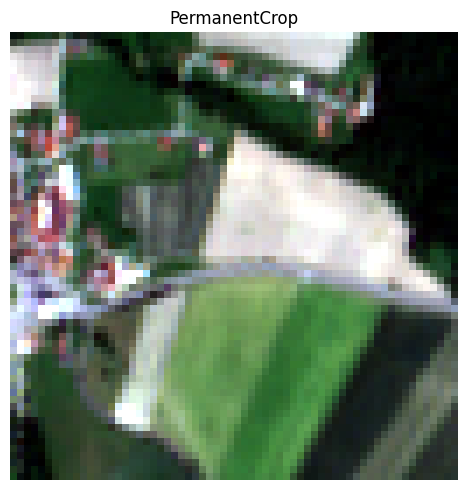

In [58]:
#Manual plausibility check by looking at one images and corresponding label
import matplotlib.pyplot as plt
import random
i = random.randint(0, len(testimages_np))
fig, axs = plt.subplots(1, figsize=(5,5))

axs.imshow(testimages_np[i], interpolation='none')
axs.set_title(predicted_labels[i])
axs.axis(False)

plt.tight_layout()
plt.show()

In [60]:
#export csv
import csv

# Specify the name of the CSV file you want to create
csv_file_name = "schnitzel_bratwürst_classification.csv"

# Open a new CSV file in write mode
with open(csv_file_name, mode='w', newline='') as file:
    writer = csv.writer(file)

    # Write the header row
    writer.writerow(["test_id", "label"])

    # Write the data rows
    for index in range(len(testimages_np)):
        writer.writerow([index, predicted_labels[index]])

print(f"CSV file '{csv_file_name}' created successfully.")


CSV file 'schnitzel_bratwürst_classification.csv' created successfully.
